In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet, Constraint, Param
from pyomo.dae import *

import jax
import jax.numpy as jnp

from scipy.interpolate import interp1d

import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

### `ode_func` has to be replaced by a `neural network`

In [22]:
def ode_func(y, t, c = 1):
    return -c*y

In [38]:
pyo.tanh(-5)

-0.9999092042625951

Ipopt 3.14.16: max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:     4459
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4186

Total number of variables............................:       91
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49

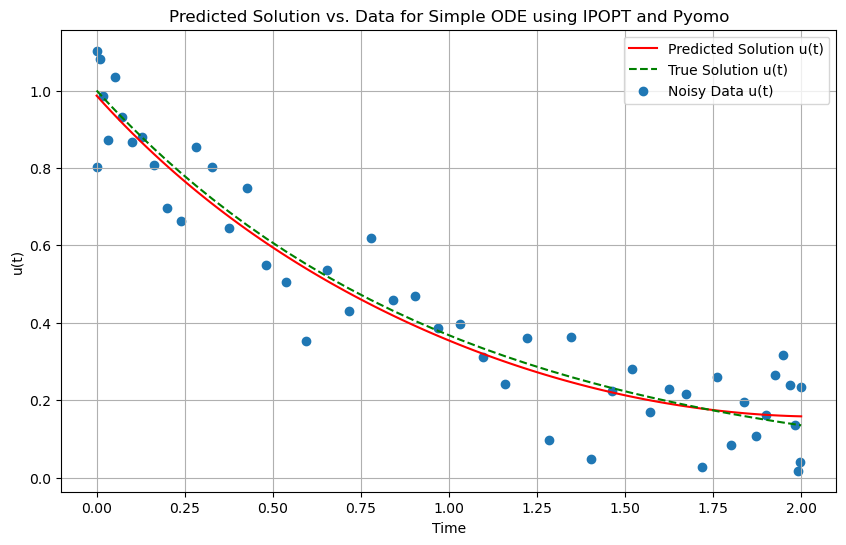

In [68]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 50
noise_level = 0.1
ode_type = "decay"
params = {"c": 1}
start_time=0
end_time=2
spacing_type="chebyshev"
initial_state = jnp.array([1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, len(y_noisy)-1)

#---------------------------VARIABLE DEFINITIONS--------------------------#
model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
# model.C = pyo.Var(domain=pyo.Reals, initialize=1.0) # adding c as a variable

input_size = 2  # t, u
hidden_size = 10 
output_size = 1  # u

#--------------------WEIGHTS AND BIASES----------------------#
def initialize_weights(shape):
    return np.random.randn(*shape) * 0.1

def initialize_biases(size):
    return np.random.randn(size) * 0.1

model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: initialize_weights((hidden_size, input_size))[i, j])
model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: initialize_biases(hidden_size)[i])
model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: initialize_weights((output_size, hidden_size))[i, j])
model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: initialize_biases(output_size)[i])

#---------------------------INITIAL CONDITIONS---------------------------#
# model.initial_conditions = ConstraintList() 
# model.initial_conditions.add(model.u[0] == 1.0)

#---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
def nn_output(t, u, m):
    # Hidden layer (tanh activation)
    hidden_layer = [sum(m.W1[i, j] * (t if j == 0 else u) for j in range(input_size)) + m.b1[i] for i in range(hidden_size)]
    hidden_layer_tanh = [pyo.tanh(z) for z in hidden_layer]
    
    # Output layer
    output = sum(m.W2[0, i] * hidden_layer_tanh[i] for i in range(hidden_size)) + m.b2[0]
    return output

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
penalty_terms = []
penalty_lambda = 500
# ODE constraints using collocation matrix
model.ode = ConstraintList()
for i in range(1, N):
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
        # collocation constraints using the neural network function
    collocation_constraint = nn_output(t[i], model.u[i], model) - du_dt
    model.ode.add(collocation_constraint == 0)
    
    penalty_terms.append((collocation_constraint)**2)

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    data_fit = sum((m.u[i] - y_noisy[i])**2 for i in m.t_idx)
    penalty = penalty_lambda * sum(penalty_terms)
    return penalty + data_fit

model.obj = Objective(rule=_objective, sense=pyo.minimize)
    
#---------------------------SOLVING THE MODEL--------------------------#
solver = pyo.SolverFactory('ipopt')

"""solver.options['tol'] = 1e-6
solver.options['bound_push'] = 1e-8
solver.options['constr_viol_tol'] = 1e-8"""

solver.options['max_iter'] = 500
solver.solve(model, tee=True)

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
# print(f"{value(model.C):.4f}")

#---------------------------INTERPOLATION--------------------------#
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], 100)
y_new = interp_fn(x_new)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 6))
plt.plot(x_new, y_new, 'r', label='Predicted Solution u(t)')
plt.plot(t, y, 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy, label='Noisy Data u(t)')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using IPOPT and Pyomo')
plt.grid(True)
plt.show()

----

In [ ]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 50
noise_level = 0.1
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=2
spacing_type="chebyshev"
initial_state = jnp.array([1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#---------------------------COLLOCATION MATRIX--------------------------#
weights = compute_weights(t)
D = lagrange_derivative(t, weights)
D = np.array(D)

#---------------------------MODEL CREATION--------------------------#
model = ConcreteModel()
model.t_idx = RangeSet(0, len(y_noisy)-1)
model.dim_idx = RangeSet(0, 1)  # ???

#---------------------------VARIABLE DEFINITIONS--------------------------#
model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)
model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1)

input_size = 3  # t, u, v
hidden_size = 10  
output_size = 2  # u and v

#--------------------WEIGHTS AND BIASES----------------------#
def initialize_weights(shape):
    return np.random.randn(*shape) * 0.1

def initialize_biases(size):
    return np.random.randn(size) * 0.1

model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: initialize_weights((hidden_size, input_size))[i, j])
model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: initialize_biases(hidden_size)[i])
model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: initialize_weights((output_size, hidden_size))[i, j])
model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: initialize_biases(output_size)[i])

#---------------------------INITIAL CONDITIONS---------------------------#
# model.initial_conditions = ConstraintList() 
# model.initial_conditions.add(model.u[0] == 1.0)

#---------------------------NEURAL NETWORK DEFINITIONS---------------------------#
def nn_output(t, u, v, m):
    # Hidden layer (tanh activation)
    hidden_layer = [sum(m.W1[i, j] * (t if j == 0 else u if j == 1 else v) for j in range(input_size)) + m.b1[i] for i in range(hidden_size)]
    hidden_layer_tanh = [pyo.tanh(z) for z in hidden_layer]
    
    # Output layer
    output = [sum(m.W2[k, i] * hidden_layer_tanh[i] for i in range(hidden_size)) + m.b2[k] for k in range(output_size)]
    return output

#---------------------------ODE CONSTRAINTS USING COLLOCATION MATRIX--------------------------#
penalty_terms = []
penalty_lambda = 500
# ODE constraints using collocation matrix
model.ode = ConstraintList()
for i in range(1, N):
    du_dt = sum(D[i, j] * model.u[j] for j in range(N))
    dv_dt = sum(D[i, j] * model.v[j] for j in range(N))
    
    nn_u, nn_v = nn_output(t[i], model.u[i], model.v[i], model)
    
    collocation_constraint_u = nn_u[0] - du_dt
    collocation_constraint_v = nn_v[1] - dv_dt
    
    model.ode.add(collocation_constraint_u == 0)
    model.ode.add(collocation_constraint_v == 0)
    
    penalty_terms.append((collocation_constraint_u)**2 + (collocation_constraint_v)**2)

#---------------------------OBJECTIVE FUNCTION DEFINITION--------------------------#
def _objective(m):
    data_fit = sum((m.u[i] - y_noisy[i])**2 for i in m.t_idx)
    penalty = penalty_lambda * sum(penalty_terms)
    return penalty + data_fit

model.obj = Objective(rule=_objective, sense=pyo.minimize)
    
#---------------------------SOLVING THE MODEL--------------------------#
solver = pyo.SolverFactory('ipopt')

"""solver.options['tol'] = 1e-6
solver.options['bound_push'] = 1e-8
solver.options['constr_viol_tol'] = 1e-8"""

solver.options['max_iter'] = 500
solver.solve(model, tee=True)

#---------------------------EXTRACTING RESULTS--------------------------#
u_solution = np.array([value(model.u[i]) for i in model.t_idx])
# print(f"{value(model.C):.4f}")

#---------------------------INTERPOLATION--------------------------#
interp_fn = interp1d(t, u_solution, kind='cubic', fill_value='extrapolate')
x_new = np.linspace(t[0], t[-1], 100)
y_new = interp_fn(x_new)

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 6))
plt.plot(x_new, y_new, 'r', label='Predicted Solution u(t)')
plt.plot(t, y, 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy, label='Noisy Data u(t)')
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.legend()
plt.title('Predicted Solution vs. Data for Simple ODE using IPOPT and Pyomo')
plt.grid(True)
plt.show()